# [Montbrio SDE model using Cupy](https://github.com/Ziaeemehr/vbi_paper/blob/main/docs/examples/mpr_sde_cupy.ipynb)

Estimation of global coupling $G$.

<a href="https://colab.research.google.com/github/Ziaeemehr/vbi_paper/blob/main/docs/examples/mpr_sde_cupy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import os
import vbi
import torch
import numpy as np
import networkx as nx
from copy import deepcopy
import sbi.utils as utils
import matplotlib.pyplot as plt
from sbi.analysis import pairplot
from vbi.sbi_inference import Inference
from vbi.models.cupy.mpr import MPR_sde

import warnings
warnings.filterwarnings("ignore")

In [19]:
seed = 42
np.random.seed(seed)
path = "output/mpr_sde_cupy_"
os.makedirs(path, exist_ok=True)
LOAD_DATA = True

In [20]:
LABESSIZE = 10
plt.rcParams['axes.labelsize'] = LABESSIZE
plt.rcParams['xtick.labelsize'] = LABESSIZE
plt.rcParams['ytick.labelsize'] = LABESSIZE

loading connectivity matrix

In [21]:
D = vbi.LoadSample(nn=88)
weights = D.get_weights()
nn = weights.shape[0]
print(f"number of nodes: {nn}")

number of nodes: 88


Simulating BOLD single for a sample value of $G$

In [22]:
TR = 300.0
fs = 1 / (TR / 1000)
t_cut = 20
par = {
    "G": 0.506,  # global coupling strength
    "weights": weights,  # connection matrix
    "method": "heun",  # integration method
    "dt": 0.01,
    "t_cut": 20_000,
    "t_end": 100_000,  # [ms]
    "num_sim": 1,  # number of simulations
    "tr": TR,
    "rv_decimate": 10,
    "engine": "cpu",  # cpu or gpu
    "seed": seed,  # seed for random number generator
    "RECORD_RV": True,
    "RECORD_BOLD": True,
}

In [54]:
if LOAD_DATA and os.path.exists(path + "/bold_obs.npz"):
    sol = np.load(path + "/bold_obs.npz")
else:
    obj = MPR_sde(par)
    # print(obj())
    sol = obj.run()

Integrating:   0%|          | 0/999999 [00:00<?, ?it/s]

Integrating: 100%|██████████| 999999/999999 [02:33<00:00, 6530.89it/s]


In [55]:
rv_d = sol["rv_d"]
rv_t = sol["rv_t"] / 1000
fmri_d = sol["fmri_d"]
fmri_t = sol["fmri_t"] / 1000

print(np.isnan(fmri_d).sum(), np.isnan(rv_d).sum())
print(f"rv_t.shape = {rv_t.shape}")
print(f"rv_d.shape = {rv_d.shape}")
print(f"fmri_d.shape = {fmri_d.shape}")
print(f"fmri_t.shape = {fmri_t.shape}")

if (not LOAD_DATA) or (not os.path.exists(path + "/bold_obs.npz")):
    np.savez(
        path + "/bold_obs.npz", 
        fmri_t=fmri_t, 
        fmri_d=fmri_d, 
        rv_d=rv_d,
        rv_t=rv_t,
        G=par["G"]
    )

0 0
rv_t.shape = (79999,)
rv_d.shape = (79999, 176, 1)
fmri_d.shape = (266, 88, 1)
fmri_t.shape = (266,)


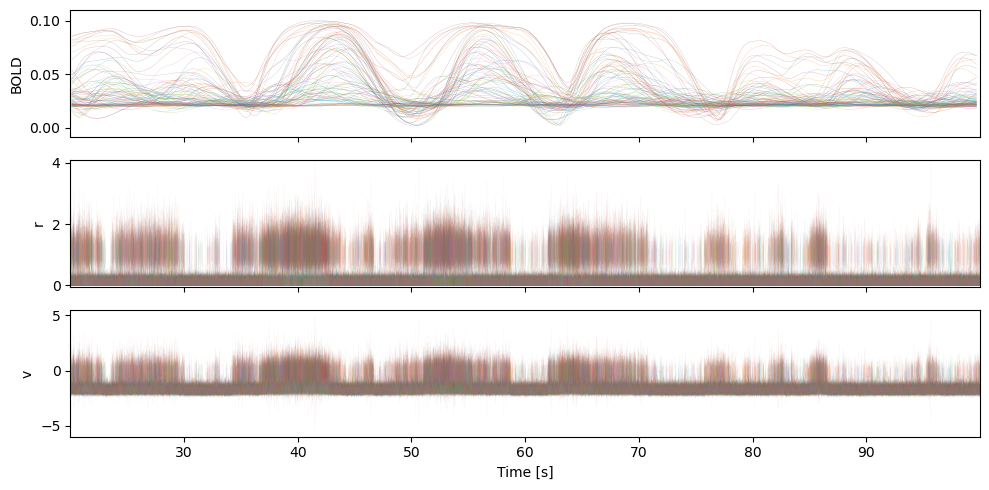

In [28]:
if fmri_d.ndim == 3:
    fig, ax = plt.subplots(3, figsize=(10, 5), sharex=True)
    ax[0].set_ylabel("BOLD")
    ax[0].plot(fmri_t, fmri_d[:,:,0], lw=0.1)
    ax[0].margins(0, 0.1)
    ax[1].plot(rv_t, rv_d[:, :nn, 0], lw=0.1, alpha=0.1)
    ax[2].plot(rv_t, rv_d[:, nn:, 0], lw=0.1, alpha=0.1)
    ax[1].set_ylabel("r")
    ax[2].set_ylabel("v")
    ax[2].set_xlabel("Time [s]")
    ax[1].margins(0, 0.01)
    plt.tight_layout()
    plt.show()


**Training data**

- Uniform prior for $G$ and sampling from prior;
- Selecting GPU as engine;
- Storing training BOLD signals;
- Extracting features from the simulated BOLD signals;
- Visualizing some of the features;
- Training NN and estimating parameter of G for given observed signal;
- Visualising the posterior distribution.


In [31]:
num_sim = 512
G_min, G_max = 0.0, 1.0

prior_min = [G_min]
prior_max = [G_max]
prior = utils.torchutils.BoxUniform(
    low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max)
)

obj = Inference()
theta = obj.sample_prior(prior, num_sim, seed=seed)

par_batch = deepcopy(par)
par_batch['G'] = theta.numpy().astype(np.float64).squeeze()
par_batch['num_sim'] = num_sim
par_batch['engine'] = 'gpu'
par_batch['RECORD_RV'] = False

In [43]:
if LOAD_DATA and os.path.exists(path + "/bolds.npz"):
    sol = np.load(path + "/bolds.npz")
    print(sol.files)
else:
    obj = MPR_sde(par_batch)
    sol = obj.run()

['fmri_d', 'fmri_t', 'theta']


In [44]:
fmri_d = sol["fmri_d"]
fmri_t = sol["fmri_t"]
fmri_d = fmri_d
fmri_t = fmri_t
bolds = np.transpose(fmri_d, (2, 1, 0))

if not LOAD_DATA:
    np.savez(path + "/bolds.npz", fmri_d=bolds, fmri_t=fmri_t, theta=theta.numpy().squeeze())
print(f"fmri_d.shape = {fmri_d.shape}")
print(f"fmri_t.shape = {fmri_t.shape}")
print(f"theta.shape = {theta.shape}")
print(f"bolds.shape = {bolds.shape}")

fmri_d.shape = (266, 88, 512)
fmri_t.shape = (266,)
theta.shape = torch.Size([512, 1])
bolds.shape = (512, 88, 266)


In [47]:
theta = np.load(path + "/bolds.npz")["theta"]
theta = torch.tensor(theta).float()
theta.shape

torch.Size([512])

In [48]:
from vbi import (
    get_features_by_domain,
    get_features_by_given_names,
    report_cfg,
    extract_features,
)

cfg = get_features_by_domain("connectivity")
cfg = get_features_by_given_names(cfg, ["fcd_stat"])
report_cfg(cfg)

Selected features:
------------------
■ Domain: connectivity
 ▢ Function:  fcd_stat
   ▫ description:  Extracts features from dynamic functional connectivity (FCD)
   ▫ function   :  vbi.feature_extraction.features.fcd_stat
   ▫ parameters :  {'TR': 1.0, 'win_len': 30, 'positive': False, 'eigenvalues': True, 'masks': None, 'verbose': False, 'pca_num_components': 3, 'quantiles': [0.05, 0.25, 0.5, 0.75, 0.95], 'k': None, 'features': ['sum', 'max', 'min', 'mean', 'std', 'skew', 'kurtosis']}
   ▫ tag        :  ['fmri', 'eeg', 'meg']
   ▫ use        :  yes


In [49]:
df = extract_features(bolds, fs, cfg, n_workers=10, output_type="dataframe")
df = df[["fcd_full_sum", "fcd_full_ut_std"]]
df['G'] = theta.numpy().squeeze()
df.to_csv(path + "/g_cupy_features.csv", index=False)
df.head()

100%|██████████| 512/512 [00:04<00:00, 108.12it/s]


,fcd_full_sum,fcd_full_ut_std,G
0,7322.430664,0.033037,0.429404
1,NaN,NaN,0.885443
2,7455.405273,0.032545,0.573904
3,6776.824219,0.025232,0.266580
4,7109.461426,0.025811,0.627449


In [50]:
df.columns

Index(['fcd_full_sum', 'fcd_full_ut_std', 'G'], dtype='object')

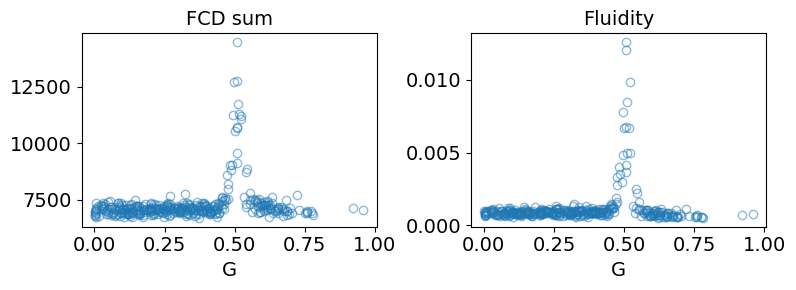

In [51]:
LABELSIZE = 14
plt.rc('axes', labelsize=LABELSIZE)
plt.rc('axes', titlesize=LABELSIZE)
plt.rc('figure', titlesize=LABELSIZE)
plt.rc('legend', fontsize=LABELSIZE)
plt.rc('xtick', labelsize=LABELSIZE)
plt.rc('ytick', labelsize=LABELSIZE)

f_kwargs = {
    "lw": 1,
    "alpha": 0.5,
    "marker": "o",
    "linestyle": "",
    "markerfacecolor": "none",
}

fig, ax = plt.subplots(1,2, figsize=(8, 3))
ax[0].plot(df["G"], df["fcd_full_sum"], **f_kwargs)
ax[1].plot(df["G"], df["fcd_full_ut_std"]**2, **f_kwargs)

titles = ["FCD sum", "Fluidity"]
for i in range(2):
    ax[i].set_xlabel("G")
    ax[i].set_title(titles[i])
plt.tight_layout()

In [52]:
# drop G column
X = df.drop(columns=["G"]).values
X = torch.tensor(X, dtype=torch.float32)

In [53]:
obj_inf = Inference()
posterior = obj_inf.train(theta, X, prior=prior, num_threads=4)

 Neural network successfully converged after 265 epochs.train Done in 0 hours 0 minutes 06.043956 seconds


Observation point

100%|██████████| 1/1 [00:00<00:00,  8.79it/s]


  0%|          | 0/10000 [00:00<?, ?it/s]

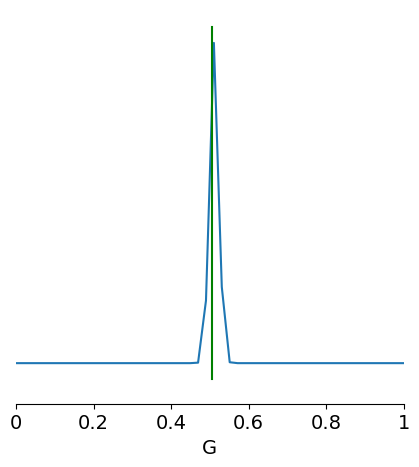

In [61]:
bold_obs = np.load(path+"/bold_obs.npz")['fmri_d']
bold_obs = np.transpose(bold_obs, (2, 1, 0))


x_obs = extract_features(bold_obs, 0.3, cfg, output_type="dataframe")
x_obs = x_obs[["fcd_full_sum", "fcd_full_ut_std"]].values
samples = obj_inf.sample_posterior(x_obs, 10000, posterior)

limits = [[i, j] for i, j in zip(prior_min, prior_max)]
fig, ax = pairplot(
    samples,
    points=[par['G']],
    figsize=(5, 5),
    limits=limits,
    labels=["G"],
    diag="kde",
    fig_kwargs=dict(
        points_offdiag=dict(marker="*", markersize=10),
        points_colors=["g"],
    ),
)